In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from mpl_plotter.two_d import line, heatmap
from mpl_plotter.three_d import surface
# from tqdm import

In [2]:
connectivity_min, connectivity_max = 0,65
# random_input_span = (1.2,2.8)
random_input_span = (9.5,13.5)
total_time = 100
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational']
neuron_model = current_models[1]

model_folder_name = neuron_model+'_ensembles'
version = '_cluster_computed'

# Capture related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [6]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model == 'Rotational': #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model == 'Rotational':amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [7]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

In [8]:
plt.rc('font', family='serif')

# Sigma dataframe

In [9]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.02,0.211193,0.199566,0.170038,0.151700,0.141361,0.132285,0.127606,0.122086,0.118591,0.116013,...,0.112233,0.108701,0.108748,0.110108,0.108198,0.108322,0.109212,0.107943,0.107053,0.107551
0.04,0.212954,0.205996,0.190124,0.174102,0.167068,0.163210,0.160514,0.157813,0.154730,0.154123,...,0.149304,0.152267,0.150494,0.150708,0.152745,0.152914,0.150270,0.150445,0.151531,0.152406
0.06,0.214767,0.210210,0.205422,0.200107,0.193270,0.190214,0.186441,0.183353,0.183375,0.182612,...,0.188434,0.189664,0.189129,0.199757,0.229999,0.247700,0.251547,0.258701,0.260710,0.263001
0.08,0.215933,0.212075,0.208775,0.205795,0.204537,0.204474,0.204279,0.203307,0.203434,0.205445,...,0.294920,0.321749,0.331351,0.337738,0.339209,0.338311,0.337945,0.336637,0.336793,0.335062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.90,0.445733,0.403955,0.380817,0.375043,0.386864,0.448854,0.743276,0.849515,0.843898,0.833998,...,0.754863,0.749075,0.718797,0.707508,0.701180,0.693438,0.685773,0.677994,0.672105,0.664148
4.92,0.446391,0.404489,0.382100,0.374792,0.386403,0.449275,0.743692,0.846482,0.844340,0.835722,...,0.757309,0.746061,0.716252,0.709357,0.701539,0.691967,0.686802,0.679760,0.672040,0.665699
4.94,0.446587,0.405463,0.382677,0.376355,0.388554,0.449330,0.741929,0.846776,0.842691,0.832075,...,0.756294,0.742162,0.716696,0.710962,0.702047,0.697298,0.688253,0.681255,0.674237,0.663039


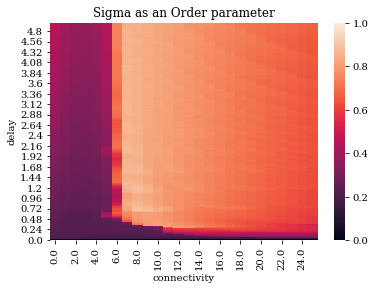

In [10]:
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)
ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

In [11]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

# Amin Saman Parameter

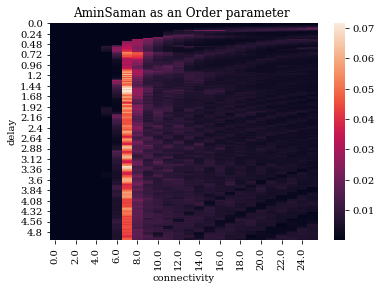

In [12]:
if neuron_model == 'Rotational':
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))

# Field period dataframe

In [13]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0
delay,,,,,,,,,,,,,,,,,,,,,
0.00,100.00000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.02,0.46729,0.529101,0.588235,0.645161,0.699301,0.75188,0.800000,0.847458,0.892857,0.645161,...,0.398406,0.406504,0.416667,0.425532,0.434783,0.442478,0.452489,0.458716,1.162791,1.515152
0.04,0.46729,0.529101,0.588235,0.645161,0.699301,0.75188,0.819672,0.854701,0.892857,0.943396,...,1.190476,0.245098,1.250000,1.282051,1.315789,1.449275,1.470588,1.470588,0.233100,0.236407
0.06,0.46729,0.529101,0.591716,0.645161,0.699301,0.75188,0.800000,0.847458,0.892857,0.943396,...,0.714286,1.234568,0.282486,0.281690,0.285714,0.292398,0.294985,0.300300,0.304878,0.309598
0.08,0.46729,0.529101,0.588235,0.645161,0.699301,0.75188,0.800000,0.854701,0.892857,0.970874,...,0.337838,0.344828,0.353357,0.361011,0.369004,0.374532,0.380228,0.386100,0.392157,0.396825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.90,100.00000,16.666667,11.111111,11.111111,10.000000,10.00000,10.000000,10.000000,11.111111,11.111111,...,14.285714,14.285714,14.285714,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667
4.92,100.00000,16.666667,11.111111,11.111111,10.000000,10.00000,10.000000,10.000000,11.111111,11.111111,...,14.285714,14.285714,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667
4.94,100.00000,16.666667,11.111111,11.111111,10.000000,10.00000,10.000000,10.000000,11.111111,11.111111,...,14.285714,14.285714,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667


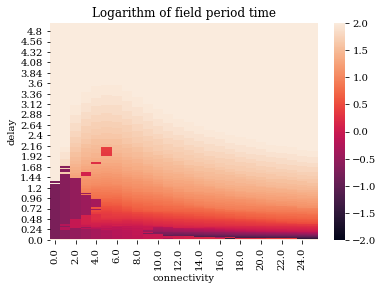

In [14]:
ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period.set_title('Logarithm of field period time')
ax_field_period.invert_yaxis()

In [15]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

In [16]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.02,257.780524,257.052273,227.662781,198.918400,171.512599,130.539951,126.716494,102.410615,85.235980,69.907610,...,61.679249,58.486743,55.031863,57.172440,55.696194,55.838366,53.710326,56.009784,50.971763,50.374561
0.04,243.574818,247.687607,224.769435,196.421945,178.166396,157.178293,110.928142,101.709847,120.487435,107.472724,...,82.542682,90.600117,85.042097,85.592389,86.778814,76.558571,74.565918,74.889551,107.053364,141.993106
0.06,261.033408,275.127779,226.049861,212.313656,199.121375,186.386668,157.305115,165.807179,138.420278,123.623705,...,103.363519,109.131735,102.438982,268.457189,533.938395,557.022930,1004.939301,978.553063,971.107464,882.867923
0.08,260.618965,243.408296,222.905303,208.362054,232.869499,236.989113,180.218146,161.034160,158.713677,132.956536,...,801.544960,1231.270484,1501.121143,1151.032259,1209.164226,1544.100239,1370.495063,1690.104030,1257.957772,1148.957722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.90,907.863239,700.860692,687.103653,768.698413,1002.536441,1732.571343,4372.284465,4035.361844,5205.952111,4821.719298,...,3997.828048,3361.951889,2458.325754,2900.207592,3193.649890,3222.135056,3090.566955,2823.104156,2465.442568,2089.413506
4.92,912.035348,704.157412,690.573322,771.559065,1000.636585,1726.849526,4294.087463,3725.156781,5286.817833,4665.201746,...,3960.057928,3284.123259,2392.898101,2963.265229,3220.687492,3224.518577,3079.129907,2794.944561,2406.541019,2002.616912
4.94,914.432025,706.961510,692.264835,777.975835,1002.862259,1721.484725,4183.905428,3470.648487,5356.327164,4483.000820,...,3907.316372,3163.643050,2546.979753,3098.703705,3271.386296,3269.466091,3062.118283,2733.535019,2321.479462,1972.047428


<IPython.core.display.Javascript object>


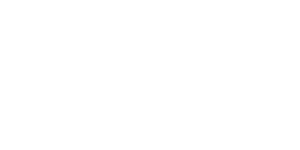

In [17]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

d_arr = max_intensity_table.index
g_arr = max_intensity_table.columns
bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

dd_arr = d_arr[1] - d_arr[0]
dg_arr = g_arr[1] - g_arr[0]

dmax_intensity = max_intensity_table.to_numpy().flatten()

cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
period_arr = field_period_table.to_numpy().flatten()
max_height = np.max(period_arr)   # get range of colorbars so we can normalize
min_height = np.min(period_arr)
# scale each z to [0,1], and get their rgb values
rgba = [cmap( np.log( k ) ) for k in period_arr] 


fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)